* load lightning module from checkpoints
* eval models with various decision score on metrics
* visualisation sample

In [1]:
import hydra
from src.commons.constants import PROJECT_PATH
from omegaconf import DictConfig, OmegaConf

import numpy as np
import cv2
from PIL import Image
import torch
import pytorch_lightning as pl
import pandas as pd
import os
from copy import deepcopy
import torch.nn.functional as F
from torchmetrics import Metric
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
from torch.utils import data
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

from src.commons.utils_io import load_sam, make_path, check_dir
from src.commons.utils import *
from src.models.commons.mask_process import extract_object_from_batch, binarize_mask
from src.commons.constants import *
from src.data.process import generate_grid_prompt
from src.models.magic_pen.task import MagicPenModule

### Load config from run

Inside a Lightning checkpoint you’ll find:

* 16-bit scaling factor (if using 16-bit precision training)
* Current epoch
* Global step
* LightningModule’s state_dict
* State of all optimizers
* State of all learning rate schedulers
* State of all callbacks (for stateful callbacks)
* State of datamodule (for stateful datamodules)
* The hyperparameters (init arguments) with which the model was created
* The hyperparameters (init arguments) with which the datamodule was created 
* State of Loops

In [2]:
_SHARE_PATH = "levir-cd/vit-b"

def _cfg_meta(exp_name, id_exp, folder_root=None, description=""):
    """generate register items - to be updated"""
    if folder_root is None: folder_root = ""
    cfg = {
        "path": make_path(
                    id_exp, 
                    LOGS_PATH, 
                    folder_root,
                    exp_name,
                    _SHARE_PATH
                ),
        "description": description
    }

    if not os.path.exists(cfg["path"]): 
        raise FileNotFoundError(f"Exp run logs not found :{cfg['path']}")
    return cfg

# TODO: integrate in src/
_register_runs = {
    "probing_concat_baseline": 
        _cfg_meta("train_probing_concat", "2024-08-07_17-50-07", folder_root="08082024_train_first_modules", description=""),
    "probing_diff_baseline":
        _cfg_meta("train_probing_diff", "2024-08-07_17-50-30", folder_root="08082024_train_first_modules", description=""),
    "probing_attn_baseline":
        _cfg_meta("train_probing_attn", "2024-08-07_17-51-53", folder_root="08082024_train_first_modules", description=""),
    "adapter_diff":
        _cfg_meta("train_adapter_diff", "2024-08-07_17-52-31", folder_root="08082024_train_first_modules", description=""),
    "adapter_concat":
        _cfg_meta("train_adapter_concat", "2024-08-07_17-53-32", folder_root="08082024_train_first_modules", description=""),
    "adapter_attn":
        _cfg_meta("train_adapter_attn", "2024-08-07_18-15-08", folder_root="08082024_train_first_modules", description=""),
    "lora_diff":
        _cfg_meta("train_lora_diff", "2024-08-07_18-22-22", folder_root="08082024_train_first_modules", description=""),
    "lora_concat":
        _cfg_meta("train_lora_concat", "2024-08-07_18-21-49", folder_root="08082024_train_first_modules", description=""),
    "lora_attn":
        _cfg_meta("train_lora_attn", "2024-08-07_18-22-20", folder_root="08082024_train_first_modules", description=""),
    "adapter_attnconc_bce_lr3x10-4":
        _cfg_meta("adapter_attnconc_bce_lr3x10-4", "1387852", folder_root="", description=""),
}

def find_best_ckpt(run_path):
    run_path = os.path.join(run_path, "checkpoints")
    fname = [_ for _ in os.listdir(run_path) if _.startswith("epoch_")]
    if fname:
        fname=fname[0]
    else:
        raise ValueError("ckpt not found")
    return make_path(fname, run_path)

def check_exp(exp_name):
    if exp_name not in _register_runs:
        raise ValueError(f"Exp name {exp_name} not found")

def _cfg_path(exp_name):
    check_exp(exp_name)
    return make_path(
        ".hydra/config.yaml",
        _register_runs[exp_name]["path"],
        )

def _ckpt_path(exp_name):
    check_exp(exp_name)
    return find_best_ckpt(_register_runs[exp_name]["path"])

def load_default_loss():
    return nn.BCEWithLogitsLoss()

In [3]:
#model.optimzier.load_state_dict(MyMode.load_optimizer_checkpoint(last_checkpoint))

In [4]:
def load_cfg(exp_name):
    return OmegaConf.load(_cfg_path(exp_name))


def load_params_module(cfg):
    scheduler, optimizer = None, None
    loss = load_default_loss()
    model = hydra.utils.instantiate(cfg.model.instance.network)
    if "optimizer" in cfg.model:
        optimizer = hydra.utils.instantiate(cfg.model.optimizer)
    if "scheduler" in cfg.model:
        scheduler = hydra.utils.instantiate(cfg.model.scheduler)
    if "loss" in cfg.model:
        loss = hydra.utils.instantiate(cfg.model.loss)
        
    return dict(model=model, optimizer=optimizer, scheduler=scheduler, loss=loss, task_name=cfg.task_name)

def load_dmodule(cfg):
    return hydra.utils.instantiate(cfg.data)

def load_lmodule(exp_name, params):
    return MagicPenModule.load_from_checkpoint(
        _ckpt_path(exp_name),
        optimizer=params.get("optimizer"),
        scheduler=params.get("scheduler"),
        loss=params.get("loss"),
        network = params.get("model"),
        task_name=params.get("task_name")
    )

def load_exp(exp_name):
    
    cfg = load_cfg(exp_name)
    params = load_params_module(cfg)
    data_module = load_dmodule(cfg)
    module = load_lmodule(exp_name, params)
    
    return cfg, data_module, module

In [5]:
exp_name = "probing_concat_baseline"
cfg, data_module, module = load_exp(exp_name)

INIT VIT


2024-08-26 15:46:22,676 - INFO ::  Weights loaded for : ['image_encoder']


#### Restoring Training State
If you don’t just want to load weights, but instead restore the full training, do the following:
```
model = LitModel()
trainer = Trainer(resume_from_checkpoint='some/path/to/my_checkpoint.ckpt')

# automatically restores model, epoch, step, LR schedulers, apex, etc...
trainer.fit(model)
```

### Run inference

In [6]:
def get_dloader(mode: str, dmodule):

    def wrap_mode(mode):
        if mode == "train":
            return "fit"
        return mode
    if not dmodule.ds_dict_type:
        mode_ = wrap_mode(mode)
        dmodule.setup(mode_)
    factory_dl = {
        "train": dmodule.train_dataloader,
        "val": dmodule.val_dataloader,
        "test": dmodule.test_dataloader,
    }
    return factory_dl[mode]()

def get_ds(mode: str, dmodule):
    
    def wrap_mode(mode):
        if mode == "train":
            return "fit"
        return mode
        
    if not dmodule.ds_dict_type:
        mode_ = wrap_mode(mode)
        dmodule.setup(mode_)
        
    return dmodule.ds_dict_type[mode]

In [7]:
dloader = get_dloader("test", data_module)
ds = get_ds("test", data_module)

In [8]:
batch = next(iter(dloader))

shape torch.Size([133, 1024, 1024])
shape torch.Size([7, 1024, 1024])
shape torch.Size([12, 1024, 1024])
shape torch.Size([13, 1024, 1024])
shape torch.Size([11, 1024, 1024])
shape torch.Size([48, 1024, 1024])
shape torch.Size([6, 1024, 1024])
shape torch.Size([57, 1024, 1024])
shape torch.Size([14, 1024, 1024])
shape torch.Size([80, 1024, 1024])
shape torch.Size([9, 1024, 1024])


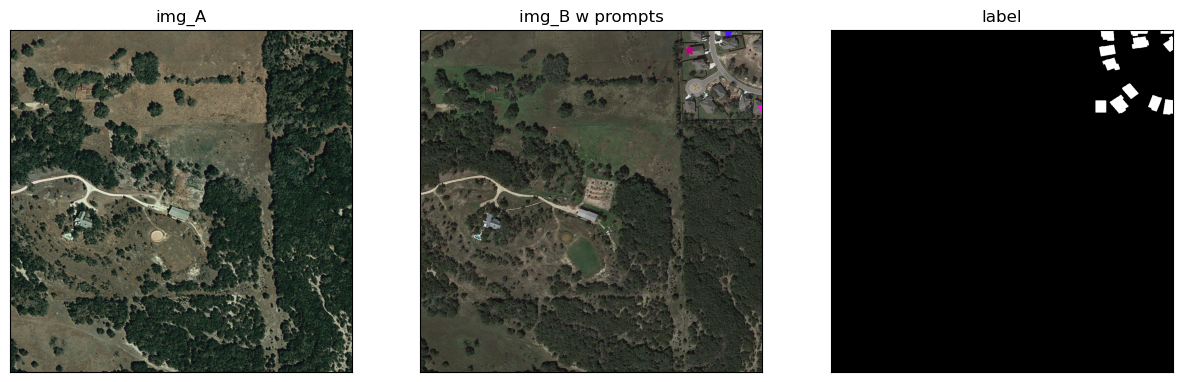

In [9]:
show_sample_from_batch(batch, idx=0)

In [10]:
def infer_on_sample(ds, module, fname=None, fidx=None):
    if not any([fname, fidx]):
        raise ValueError("Please provide at least a sample name or an sample index")
    # priority to fname
    if fname is not None:
        fidx = ds.get_from_name(fname, return_sample=False)
    # TODO: allow indices sequence
    if isinstance(fidx, int): fidx = [fidx]
    sub_dl = data.DataLoader(data.Subset(ds, fidx), batch_size=1, shuffle=False)
    batch = next(iter(sub_dl))

    # workaround  prevent wrong device association buffers in SAM
    # module = module.to("cpu")
    preds, _ = module(batch)
    # B x 1 x 1024 x 1024
    preds = preds.squeeze().detach().cpu()
    label = label.squeeze().detach().cpu()
    return preds, label, batch

In [11]:
def convert_to_device(batch, device="cuda"):
    for name in ['img_A', 'img_B', 'label', 'point_coords', 'point_labels']:
        batch[name] = batch[name].to(device)
    return batch

### Eval on instances

In [ ]:
from torchmetrics import MetricCollection
from torchmetrics.classification import BinaryF1Score, BinaryJaccardIndex, BinaryRecall, BinaryPrecision

exp_name = "adapter_diff"
ds_name = "levir-cd"
device = "cuda"
batch_size = 1
ds_type = "test"


metric_list = [
    BinaryF1Score,
    BinaryJaccardIndex,
    BinaryRecall,
    BinaryPrecision,
]

report_dir = check_dir(PROJECT_PATH, "reports", "scores", ds_name, "instances", exp_name)

labels_track = []
df_all_th = []
th_list = np.arange(0., 1, 0.1)
scores = dict(zip(th_list, [[] for _ in range(len(th_list))]))

cfg, data_module, module = load_exp(exp_name)
ds = get_ds(ds_type, data_module)
dloader = data.DataLoader(ds, batch_size=batch_size, shuffle=False)

module = module.to(device)
sgmd = nn.Sigmoid()

@torch.no_grad()
def _step(module, batch, device):
    
    batch = convert_to_device(batch, device=device)
    preds, _ = module(batch)
    preds = preds.squeeze().detach()
    #preds = sgmd(preds)
    label = batch["label"].squeeze().detach()
    return preds, label
    
for i, batch in enumerate(tqdm(dloader)):
    
    preds, label = _step(module, batch, device)
    
    for th in th_list:
        eval_engine = MetricCollection([m(threshold=th).to(device) for m in metric_list])
        scores[th].append(eval_engine(preds, label))
    
    labels_track.append(next(iter(batch["label_path"])))

for th, res in scores.items():
    df_score = pd.DataFrame(res).map(float)
    df_score = df_score.assign(
        label_path=labels_track,
        th=th
    )
    df_all_th.append(df_score)
df_all_th = pd.concat(df_all_th)
df_all_th.to_csv(make_path(f"{exp_name}.csv", report_dir), index=True)

INIT ADAPTER VIT


2024-08-26 16:51:35,213 - INFO ::  Weights loaded for : ['image_encoder']
  0%|                                                                                                                                     | 0/128 [00:00<?, ?it/s]

shape torch.Size([12, 1024, 1024])


  1%|▉                                                                                                                            | 1/128 [00:02<04:40,  2.21s/it]

shape torch.Size([48, 1024, 1024])


  2%|█▉                                                                                                                           | 2/128 [00:04<04:22,  2.08s/it]

shape torch.Size([7, 1024, 1024])


  2%|██▉                                                                                                                          | 3/128 [00:06<04:17,  2.06s/it]

shape torch.Size([11, 1024, 1024])


  3%|███▉                                                                                                                         | 4/128 [00:08<04:06,  1.99s/it]

shape torch.Size([13, 1024, 1024])


  4%|████▉                                                                                                                        | 5/128 [00:09<03:59,  1.95s/it]

shape torch.Size([6, 1024, 1024])


  5%|█████▊                                                                                                                       | 6/128 [00:11<03:59,  1.97s/it]

shape torch.Size([133, 1024, 1024])


  5%|██████▊                                                                                                                      | 7/128 [00:14<04:13,  2.10s/it]

shape torch.Size([57, 1024, 1024])


  6%|███████▊                                                                                                                     | 8/128 [00:16<04:02,  2.02s/it]

shape torch.Size([9, 1024, 1024])


  7%|████████▊                                                                                                                    | 9/128 [00:17<03:50,  1.94s/it]

shape torch.Size([105, 1024, 1024])


  8%|█████████▋                                                                                                                  | 10/128 [00:19<03:50,  1.95s/it]

shape torch.Size([14, 1024, 1024])


  9%|██████████▋                                                                                                                 | 11/128 [00:21<03:43,  1.91s/it]

shape torch.Size([104, 1024, 1024])


  9%|███████████▋                                                                                                                | 12/128 [00:23<03:42,  1.92s/it]

shape torch.Size([80, 1024, 1024])


 10%|████████████▌                                                                                                               | 13/128 [00:25<03:37,  1.89s/it]

shape torch.Size([107, 1024, 1024])


 11%|█████████████▌                                                                                                              | 14/128 [00:27<03:40,  1.93s/it]

shape torch.Size([11, 1024, 1024])


 12%|██████████████▌                                                                                                             | 15/128 [00:29<03:34,  1.90s/it]

shape torch.Size([8, 1024, 1024])


 12%|███████████████▌                                                                                                            | 16/128 [00:31<03:27,  1.85s/it]

shape torch.Size([35, 1024, 1024])


 13%|████████████████▍                                                                                                           | 17/128 [00:32<03:22,  1.82s/it]

shape torch.Size([91, 1024, 1024])


 14%|█████████████████▍                                                                                                          | 18/128 [00:34<03:25,  1.86s/it]

shape torch.Size([53, 1024, 1024])


 15%|██████████████████▍                                                                                                         | 19/128 [00:36<03:20,  1.84s/it]

shape torch.Size([195, 1024, 1024])


 16%|███████████████████▍                                                                                                        | 20/128 [00:38<03:27,  1.92s/it]

shape torch.Size([81, 1024, 1024])


 16%|████████████████████▎                                                                                                       | 21/128 [00:40<03:23,  1.90s/it]

shape torch.Size([30, 1024, 1024])


 17%|█████████████████████▎                                                                                                      | 22/128 [00:42<03:19,  1.88s/it]

shape torch.Size([34, 1024, 1024])


 18%|██████████████████████▎                                                                                                     | 23/128 [00:44<03:12,  1.84s/it]

shape torch.Size([34, 1024, 1024])


 19%|███████████████████████▎                                                                                                    | 24/128 [00:45<03:08,  1.81s/it]

shape torch.Size([32, 1024, 1024])


 20%|████████████████████████▏                                                                                                   | 25/128 [00:47<03:03,  1.78s/it]

shape torch.Size([22, 1024, 1024])


 20%|█████████████████████████▏                                                                                                  | 26/128 [00:49<03:01,  1.78s/it]

shape torch.Size([60, 1024, 1024])


 21%|██████████████████████████▏                                                                                                 | 27/128 [00:51<03:03,  1.81s/it]

shape torch.Size([96, 1024, 1024])


 22%|███████████████████████████▏                                                                                                | 28/128 [00:53<03:00,  1.80s/it]

shape torch.Size([111, 1024, 1024])


 23%|████████████████████████████                                                                                                | 29/128 [00:55<03:06,  1.88s/it]

shape torch.Size([54, 1024, 1024])


 23%|█████████████████████████████                                                                                               | 30/128 [00:56<03:02,  1.86s/it]

shape torch.Size([46, 1024, 1024])


 24%|██████████████████████████████                                                                                              | 31/128 [00:58<02:59,  1.85s/it]

shape torch.Size([19, 1024, 1024])


 25%|███████████████████████████████                                                                                             | 32/128 [01:00<02:54,  1.82s/it]

shape torch.Size([41, 1024, 1024])


 26%|███████████████████████████████▉                                                                                            | 33/128 [01:02<02:52,  1.82s/it]

shape torch.Size([106, 1024, 1024])


 27%|████████████████████████████████▉                                                                                           | 34/128 [01:04<02:55,  1.87s/it]

shape torch.Size([142, 1024, 1024])


 27%|█████████████████████████████████▉                                                                                          | 35/128 [01:06<02:59,  1.93s/it]

shape torch.Size([26, 1024, 1024])


 28%|██████████████████████████████████▉                                                                                         | 36/128 [01:08<02:54,  1.90s/it]

shape torch.Size([110, 1024, 1024])


 29%|███████████████████████████████████▊                                                                                        | 37/128 [01:10<02:58,  1.96s/it]

shape torch.Size([191, 1024, 1024])


 30%|████████████████████████████████████▊                                                                                       | 38/128 [01:12<03:01,  2.01s/it]

shape torch.Size([62, 1024, 1024])


 30%|█████████████████████████████████████▊                                                                                      | 39/128 [01:14<03:02,  2.05s/it]

shape torch.Size([29, 1024, 1024])


 31%|██████████████████████████████████████▊                                                                                     | 40/128 [01:16<02:57,  2.02s/it]

shape torch.Size([131, 1024, 1024])


 32%|███████████████████████████████████████▋                                                                                    | 41/128 [01:18<02:55,  2.01s/it]

shape torch.Size([81, 1024, 1024])


 33%|████████████████████████████████████████▋                                                                                   | 42/128 [01:20<02:51,  2.00s/it]

shape torch.Size([49, 1024, 1024])


 34%|█████████████████████████████████████████▋                                                                                  | 43/128 [01:22<02:42,  1.92s/it]

shape torch.Size([47, 1024, 1024])


 34%|██████████████████████████████████████████▋                                                                                 | 44/128 [01:24<02:40,  1.91s/it]

shape torch.Size([371, 1024, 1024])


 35%|███████████████████████████████████████████▌                                                                                | 45/128 [01:26<02:50,  2.05s/it]

shape torch.Size([142, 1024, 1024])


 36%|████████████████████████████████████████████▌                                                                               | 46/128 [01:28<02:49,  2.06s/it]

shape torch.Size([94, 1024, 1024])


 37%|█████████████████████████████████████████████▌                                                                              | 47/128 [01:30<02:44,  2.03s/it]

shape torch.Size([9, 1024, 1024])


 38%|██████████████████████████████████████████████▌                                                                             | 48/128 [01:32<02:36,  1.95s/it]

shape torch.Size([90, 1024, 1024])


 38%|███████████████████████████████████████████████▍                                                                            | 49/128 [01:34<02:33,  1.94s/it]

shape torch.Size([73, 1024, 1024])


 39%|████████████████████████████████████████████████▍                                                                           | 50/128 [01:36<02:30,  1.93s/it]

shape torch.Size([12, 1024, 1024])


 40%|█████████████████████████████████████████████████▍                                                                          | 51/128 [01:37<02:26,  1.90s/it]

shape torch.Size([57, 1024, 1024])


 41%|██████████████████████████████████████████████████▍                                                                         | 52/128 [01:39<02:24,  1.90s/it]

shape torch.Size([12, 1024, 1024])


 41%|███████████████████████████████████████████████████▎                                                                        | 53/128 [01:41<02:21,  1.89s/it]

shape torch.Size([14, 1024, 1024])


 42%|████████████████████████████████████████████████████▎                                                                       | 54/128 [01:43<02:19,  1.88s/it]

shape torch.Size([136, 1024, 1024])


 43%|█████████████████████████████████████████████████████▎                                                                      | 55/128 [01:45<02:22,  1.95s/it]

shape torch.Size([5, 1024, 1024])


 44%|██████████████████████████████████████████████████████▎                                                                     | 56/128 [01:47<02:15,  1.88s/it]

shape torch.Size([33, 1024, 1024])


 45%|███████████████████████████████████████████████████████▏                                                                    | 57/128 [01:49<02:11,  1.85s/it]

shape torch.Size([1, 1024, 1024])


 45%|████████████████████████████████████████████████████████▏                                                                   | 58/128 [01:50<02:05,  1.79s/it]

shape torch.Size([3, 1024, 1024])


 46%|█████████████████████████████████████████████████████████▏                                                                  | 59/128 [01:52<02:02,  1.78s/it]

shape torch.Size([1, 1024, 1024])


 47%|██████████████████████████████████████████████████████████▏                                                                 | 60/128 [01:54<01:58,  1.75s/it]

shape torch.Size([2, 1024, 1024])


 48%|███████████████████████████████████████████████████████████                                                                 | 61/128 [01:55<01:55,  1.72s/it]

shape torch.Size([1, 1024, 1024])


 48%|████████████████████████████████████████████████████████████                                                                | 62/128 [01:57<01:53,  1.71s/it]

shape torch.Size([2, 1024, 1024])


 49%|█████████████████████████████████████████████████████████████                                                               | 63/128 [01:59<01:52,  1.73s/it]

shape torch.Size([1, 1024, 1024])


 50%|██████████████████████████████████████████████████████████████                                                              | 64/128 [02:01<01:49,  1.71s/it]

shape torch.Size([1, 1024, 1024])


 51%|██████████████████████████████████████████████████████████████▉                                                             | 65/128 [02:02<01:47,  1.70s/it]

shape torch.Size([1, 1024, 1024])


 52%|███████████████████████████████████████████████████████████████▉                                                            | 66/128 [02:04<01:45,  1.71s/it]

shape torch.Size([90, 1024, 1024])


 52%|████████████████████████████████████████████████████████████████▉                                                           | 67/128 [02:06<01:51,  1.82s/it]

shape torch.Size([131, 1024, 1024])


 53%|█████████████████████████████████████████████████████████████████▉                                                          | 68/128 [02:08<01:52,  1.88s/it]

shape torch.Size([212, 1024, 1024])


 54%|██████████████████████████████████████████████████████████████████▊                                                         | 69/128 [02:10<01:57,  1.99s/it]

shape torch.Size([254, 1024, 1024])


 55%|███████████████████████████████████████████████████████████████████▊                                                        | 70/128 [02:13<02:00,  2.08s/it]

shape torch.Size([29, 1024, 1024])


 55%|████████████████████████████████████████████████████████████████████▊                                                       | 71/128 [02:14<01:54,  2.01s/it]

shape torch.Size([151, 1024, 1024])


 56%|█████████████████████████████████████████████████████████████████████▊                                                      | 72/128 [02:17<01:54,  2.05s/it]

shape torch.Size([64, 1024, 1024])


 57%|██████████████████████████████████████████████████████████████████████▋                                                     | 73/128 [02:18<01:48,  1.98s/it]

shape torch.Size([133, 1024, 1024])


 58%|███████████████████████████████████████████████████████████████████████▋                                                    | 74/128 [02:20<01:47,  1.98s/it]

shape torch.Size([127, 1024, 1024])


 59%|████████████████████████████████████████████████████████████████████████▋                                                   | 75/128 [02:22<01:44,  1.97s/it]

shape torch.Size([21, 1024, 1024])


 59%|█████████████████████████████████████████████████████████████████████████▋                                                  | 76/128 [02:24<01:39,  1.92s/it]

shape torch.Size([34, 1024, 1024])


 60%|██████████████████████████████████████████████████████████████████████████▌                                                 | 77/128 [02:26<01:34,  1.85s/it]

shape torch.Size([13, 1024, 1024])


 61%|███████████████████████████████████████████████████████████████████████████▌                                                | 78/128 [02:28<01:32,  1.85s/it]

shape torch.Size([24, 1024, 1024])


 62%|████████████████████████████████████████████████████████████████████████████▌                                               | 79/128 [02:29<01:29,  1.83s/it]

shape torch.Size([136, 1024, 1024])


 62%|█████████████████████████████████████████████████████████████████████████████▌                                              | 80/128 [02:32<01:31,  1.91s/it]

shape torch.Size([12, 1024, 1024])


 63%|██████████████████████████████████████████████████████████████████████████████▍                                             | 81/128 [02:33<01:28,  1.89s/it]

shape torch.Size([18, 1024, 1024])


 64%|███████████████████████████████████████████████████████████████████████████████▍                                            | 82/128 [02:35<01:24,  1.84s/it]

shape torch.Size([92, 1024, 1024])


 65%|████████████████████████████████████████████████████████████████████████████████▍                                           | 83/128 [02:37<01:25,  1.89s/it]

shape torch.Size([76, 1024, 1024])


 66%|█████████████████████████████████████████████████████████████████████████████████▍                                          | 84/128 [02:39<01:24,  1.92s/it]

shape torch.Size([78, 1024, 1024])


 66%|██████████████████████████████████████████████████████████████████████████████████▎                                         | 85/128 [02:41<01:23,  1.95s/it]

shape torch.Size([5, 1024, 1024])


 67%|███████████████████████████████████████████████████████████████████████████████████▎                                        | 86/128 [02:43<01:19,  1.89s/it]

shape torch.Size([129, 1024, 1024])


 68%|████████████████████████████████████████████████████████████████████████████████████▎                                       | 87/128 [02:45<01:20,  1.95s/it]

shape torch.Size([4, 1024, 1024])


 69%|█████████████████████████████████████████████████████████████████████████████████████▎                                      | 88/128 [02:47<01:15,  1.88s/it]

shape torch.Size([4, 1024, 1024])


 70%|██████████████████████████████████████████████████████████████████████████████████████▏                                     | 89/128 [02:49<01:12,  1.85s/it]

shape torch.Size([1, 1024, 1024])


 70%|███████████████████████████████████████████████████████████████████████████████████████▏                                    | 90/128 [02:50<01:08,  1.80s/it]

shape torch.Size([14, 1024, 1024])


 71%|████████████████████████████████████████████████████████████████████████████████████████▏                                   | 91/128 [02:52<01:08,  1.84s/it]

shape torch.Size([77, 1024, 1024])


 72%|█████████████████████████████████████████████████████████████████████████████████████████▏                                  | 92/128 [02:54<01:08,  1.89s/it]

shape torch.Size([6, 1024, 1024])


 73%|██████████████████████████████████████████████████████████████████████████████████████████                                  | 93/128 [02:56<01:04,  1.84s/it]

shape torch.Size([1, 1024, 1024])


 73%|███████████████████████████████████████████████████████████████████████████████████████████                                 | 94/128 [02:58<01:01,  1.80s/it]

shape torch.Size([1, 1024, 1024])


 74%|████████████████████████████████████████████████████████████████████████████████████████████                                | 95/128 [02:59<00:58,  1.78s/it]

shape torch.Size([2, 1024, 1024])


 75%|█████████████████████████████████████████████████████████████████████████████████████████████                               | 96/128 [03:01<00:57,  1.78s/it]

shape torch.Size([4, 1024, 1024])


 76%|█████████████████████████████████████████████████████████████████████████████████████████████▉                              | 97/128 [03:03<00:54,  1.77s/it]

shape torch.Size([1, 1024, 1024])


 77%|██████████████████████████████████████████████████████████████████████████████████████████████▉                             | 98/128 [03:05<00:52,  1.77s/it]

shape torch.Size([6, 1024, 1024])


 77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                            | 99/128 [03:06<00:51,  1.76s/it]

shape torch.Size([196, 1024, 1024])


 78%|████████████████████████████████████████████████████████████████████████████████████████████████                           | 100/128 [03:08<00:52,  1.87s/it]

shape torch.Size([28, 1024, 1024])


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████                          | 101/128 [03:10<00:50,  1.88s/it]

shape torch.Size([20, 1024, 1024])


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████                         | 102/128 [03:12<00:48,  1.85s/it]

shape torch.Size([30, 1024, 1024])


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 103/128 [03:14<00:46,  1.88s/it]

shape torch.Size([2, 1024, 1024])


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 104/128 [03:16<00:43,  1.82s/it]

shape torch.Size([82, 1024, 1024])


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 105/128 [03:18<00:42,  1.87s/it]

shape torch.Size([35, 1024, 1024])


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 106/128 [03:20<00:40,  1.86s/it]

shape torch.Size([4, 1024, 1024])


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 107/128 [03:21<00:38,  1.82s/it]

shape torch.Size([1, 1024, 1024])


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 108/128 [03:23<00:35,  1.78s/it]

shape torch.Size([3, 1024, 1024])


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 109/128 [03:25<00:34,  1.80s/it]

shape torch.Size([10, 1024, 1024])


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 110/128 [03:27<00:32,  1.83s/it]

shape torch.Size([51, 1024, 1024])


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 111/128 [03:29<00:31,  1.83s/it]

shape torch.Size([6, 1024, 1024])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 112/128 [03:30<00:29,  1.83s/it]

shape torch.Size([30, 1024, 1024])


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 113/128 [03:32<00:27,  1.85s/it]

shape torch.Size([37, 1024, 1024])


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 114/128 [03:34<00:25,  1.84s/it]

shape torch.Size([157, 1024, 1024])


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 115/128 [03:36<00:25,  1.97s/it]

shape torch.Size([6, 1024, 1024])


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 116/128 [03:38<00:22,  1.91s/it]

shape torch.Size([1, 1024, 1024])


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 117/128 [03:40<00:20,  1.85s/it]

shape torch.Size([187, 1024, 1024])


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 118/128 [03:42<00:19,  1.96s/it]

shape torch.Size([110, 1024, 1024])


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 119/128 [03:44<00:18,  2.02s/it]

shape torch.Size([142, 1024, 1024])


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 120/128 [03:46<00:16,  2.08s/it]

shape torch.Size([20, 1024, 1024])


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 121/128 [03:48<00:13,  2.00s/it]

shape torch.Size([1, 1024, 1024])


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 122/128 [03:50<00:11,  1.97s/it]

shape torch.Size([7, 1024, 1024])


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 123/128 [03:52<00:09,  1.94s/it]

shape torch.Size([35, 1024, 1024])


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 124/128 [03:54<00:07,  1.92s/it]

shape torch.Size([1, 1024, 1024])


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 125/128 [03:56<00:05,  1.89s/it]

shape torch.Size([59, 1024, 1024])


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 126/128 [03:58<00:03,  1.95s/it]

shape torch.Size([29, 1024, 1024])


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 127/128 [04:00<00:01,  1.93s/it]

shape torch.Size([3, 1024, 1024])


In [ ]:
folder_logs = make_path("instances", PROJECT_PATH, "reports", "scores", ds_name)
all_scores = []

metric_max = "BinaryF1Score"
metrics_col = [_ for _ in df.columns if _ not in ["label_path", "th"]] 

for exp_name in os.listdir(folder_logs):
    if not os.path.exists(make_path(f"{exp_name}.csv", folder_logs, exp_name)):
        print(f"{exp_name} logs file not found - please run evaluation")
        continue
    df = pd.read_csv(make_path(f"{exp_name}.csv", folder_logs, exp_name), index_col=0)
    scores = df.groupby("th")[metrics_col].mean().reset_index()
    row = scores[scores.index == scores[metric_max].idxmax()]
    row.index = [exp_name]
    all_scores.append(row)

all_scores = pd.concat(all_scores).sort_values("BinaryF1Score", ascending)

In [ ]:
all_scores

In [29]:
ls /home/MDizier/projects/stage_stylo_magique_2024/reports/scores/levir-cd/instances/probing_diff_baseline/

In [26]:
ls /home/MDizier/projects/stage_stylo_magique_2024/reports/scores/levir-cd/instances

adapter_attnconc_bce_lr3x10-4/  lora_concat/      probing_concat_baseline/
adapter_concat/                 lora_concat_k32/  probing_diff_baseline/


In [13]:
exp_name = "adapter_attnconc_bce_lr3x10-4"
ds_name = "levir-cd"
device = "cuda"
batch_size = 1
ds_type = "test"
report_dir = check_dir(PROJECT_PATH, "reports", "scores", ds_name, "instances", exp_name)

df = pd.read_csv(make_path(f"{exp_name}.csv", report_dir), index_col=0)

In [14]:
metrics_col = [_ for _ in df.columns if _ not in ["label_path", "th"]] 
scores = df.groupby("th")[metrics_col].mean()

In [15]:
df.groupby("th")[metrics_col].mean()

,BinaryF1Score,BinaryJaccardIndex,BinaryRecall,BinaryPrecision
th,,,,
0.0,0.092513,0.050943,0.921875,0.050943
0.1,0.729855,0.689416,0.782649,0.692119
0.2,0.740208,0.706774,0.764919,0.725130
0.3,0.743635,0.712864,0.750360,0.745020
0.4,0.744487,0.714570,0.737362,0.759881
0.5,0.743387,0.713090,0.723962,0.772252
0.6,0.741148,0.709538,0.710002,0.783792
0.7,0.736282,0.701774,0.693308,0.794191
0.8,0.727850,0.688286,0.671245,0.805026


In [20]:
metric = "BinaryF1Score"
scores[scores.index == scores["BinaryF1Score"].idxmax()]

In [23]:
c

,BinaryF1Score,BinaryJaccardIndex,BinaryRecall,BinaryPrecision
d,0.744487,0.71457,0.737362,0.759881


Text(0.5, 1.0, 'Scores w.r.t decision threshold - adapter_attnconc_bce_lr3x10-4 - test set')

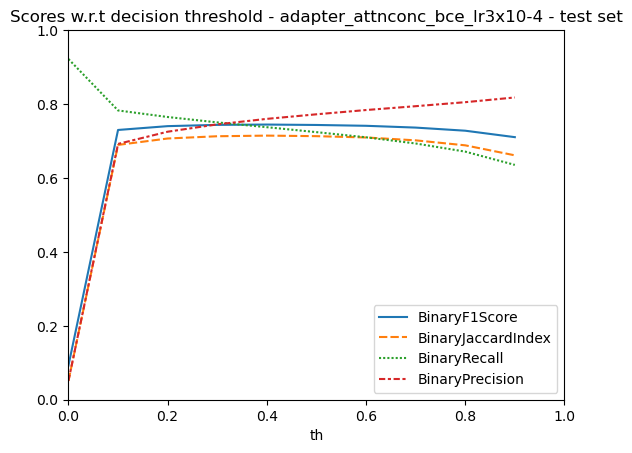

In [17]:
import seaborn as sns
sns.lineplot(scores)
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.title(f"Scores w.r.t decision threshold - {exp_name} - {ds_type} set")

Text(0.5, 1.0, 'Scores w.r.t decision threshold - lora_concat - test set')

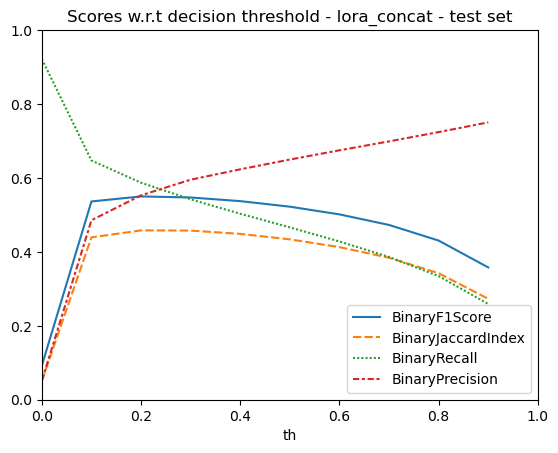

In [31]:
import seaborn as sns
sns.lineplot(scores)
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.title(f"Scores w.r.t decision threshold - {exp_name} - {ds_type} set")

In [32]:
scores

,BinaryF1Score,BinaryJaccardIndex,BinaryRecall,BinaryPrecision
th,,,,
0.0,0.092513,0.050943,0.921875,0.050943
0.1,0.536455,0.439263,0.647242,0.485639
0.2,0.550009,0.458153,0.587128,0.552963
0.3,0.547200,0.457637,0.542211,0.595356
0.4,0.537310,0.448739,0.503135,0.623360
0.5,0.522283,0.433845,0.466304,0.649807
0.6,0.501471,0.412864,0.428111,0.674824
0.7,0.472861,0.384038,0.386238,0.698962
0.8,0.430607,0.342285,0.334479,0.724117


Text(0.5, 1.0, 'Scores w.r.t decision threshold - adapter_concat - test set')

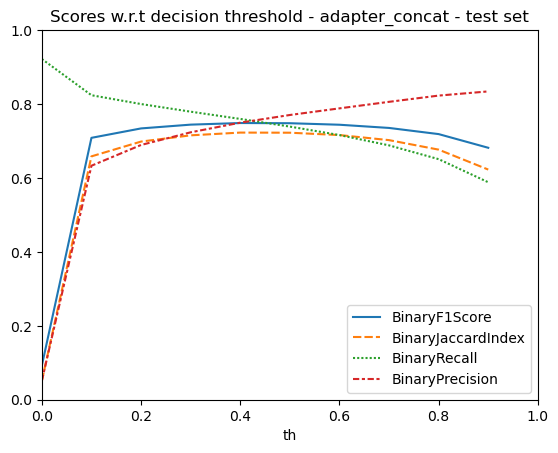

In [12]:
import seaborn as sns
sns.lineplot(scores)
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.title(f"Scores w.r.t decision threshold - {exp_name} - {ds_type} set")

In [13]:
scores

,BinaryF1Score,BinaryJaccardIndex,BinaryRecall,BinaryPrecision
th,,,,
0.0,0.092513,0.050943,0.921875,0.050943
0.1,0.708568,0.658449,0.823860,0.633089
0.2,0.734045,0.698454,0.799966,0.689255
0.3,0.744273,0.715330,0.779357,0.723501
0.4,0.748629,0.722763,0.759728,0.749624
0.5,0.748098,0.722441,0.738983,0.770367
0.6,0.744012,0.716074,0.716072,0.788306
0.7,0.735345,0.702348,0.688180,0.805981
0.8,0.718673,0.676629,0.650869,0.822859


Text(0.5, 1.0, 'Scores w.r.t decision threshold - probing_concat_baseline - test set')

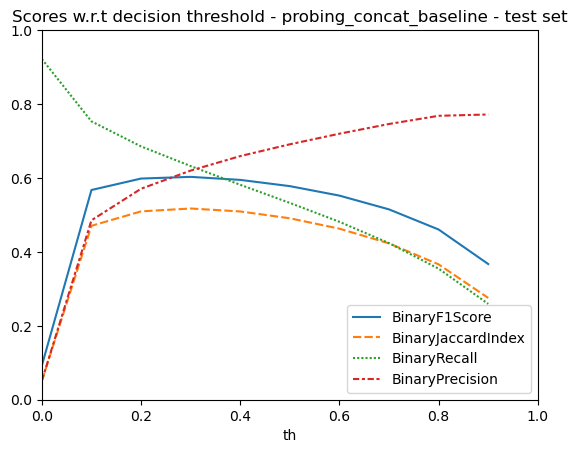

In [20]:
import seaborn as sns
sns.lineplot(scores)
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.title(f"Scores w.r.t decision threshold - {exp_name} - {ds_type} set")

Text(0.5, 1.0, 'Scores based decision threshold - probing_concat_baseline')

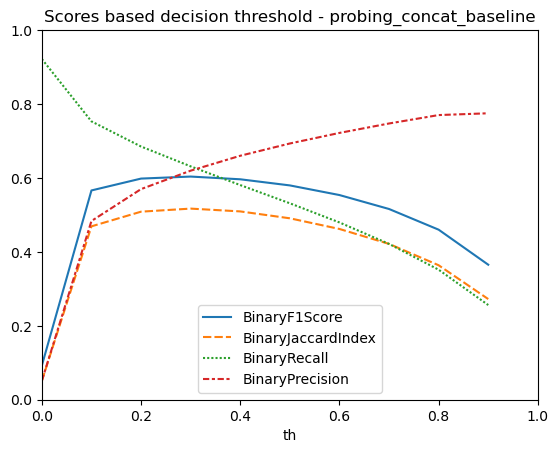

In [38]:
import seaborn as sns
sns.lineplot(scores)
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.title(f"Scores w.r.t decision threshold - {exp_name} - {ds_type} set")

In [21]:
scores

,BinaryF1Score,BinaryJaccardIndex,BinaryRecall,BinaryPrecision
th,,,,
0.0,0.092513,0.050943,0.921875,0.050943
0.1,0.567399,0.470487,0.753143,0.485380
0.2,0.598393,0.509590,0.685396,0.570842
0.3,0.602961,0.517365,0.632196,0.619935
0.4,0.594774,0.509405,0.581527,0.659160
0.5,0.577878,0.490894,0.532516,0.691078
0.6,0.552220,0.462766,0.481348,0.719750
0.7,0.514960,0.422997,0.423583,0.746034
0.8,0.460479,0.366174,0.354578,0.768174


In [35]:
scores

,BinaryF1Score,BinaryJaccardIndex,BinaryRecall,BinaryPrecision
th,,,,
0.0,0.092513,0.050943,0.921875,0.050943
0.1,0.566229,0.469083,0.753108,0.483547
0.2,0.598322,0.508797,0.685064,0.569864
0.3,0.603792,0.517091,0.631404,0.619719
0.4,0.596410,0.509497,0.580730,0.660067
0.5,0.579846,0.490847,0.531492,0.693277
0.6,0.553774,0.461988,0.479626,0.721880
0.7,0.516029,0.421604,0.421558,0.747399
0.8,0.460049,0.363825,0.351758,0.770179


## Annexes

### Influence des values null : missing labels ?

In [46]:
df[(df.BinaryJaccardIndex > 0) & (~df.BinaryJaccardIndex.isna())].groupby("th")[metrics_col].mean()

,BinaryF1Score,BinaryJaccardIndex,BinaryRecall,BinaryPrecision
th,,,,
0.0,0.100353,0.055260,1.000000,0.055260
0.1,0.624804,0.477171,0.831016,0.533569
0.2,0.665959,0.522070,0.762506,0.634284
0.3,0.677942,0.535234,0.708945,0.695825
0.4,0.675580,0.532041,0.657818,0.747687
0.5,0.662681,0.517143,0.607419,0.792317
0.6,0.632884,0.486738,0.548144,0.825006
0.7,0.595061,0.448192,0.486121,0.861865
0.8,0.535330,0.390285,0.409318,0.896209


+0.1 en enlevant les nan et 0 :o

<Axes: >

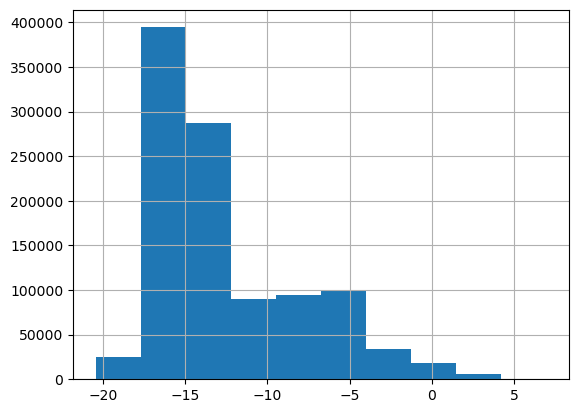

In [48]:
pd.Series(preds.flatten()).hist()

<Axes: >

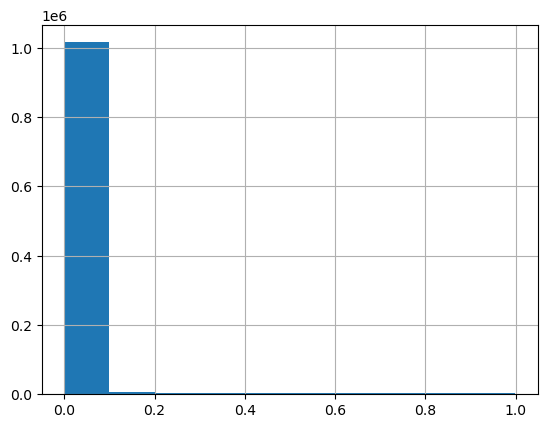

In [49]:
pd.Series(nn.Sigmoid()(preds.flatten())).hist()

<Axes: >

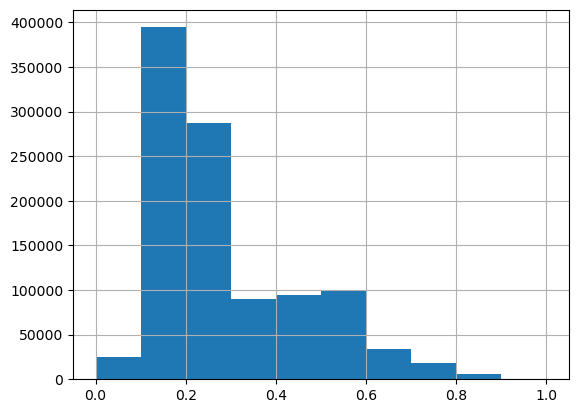

In [50]:
pd.Series(shift_range_values(preds.flatten())).hist()

In [ ]:
# NLP Example
batch, sentence_length, embedding_dim = 20, 5, 10
embedding = torch.randn(batch, sentence_length, embedding_dim)
layer_norm = nn.LayerNorm(embedding_dim)
# Activate module
layer_norm(embedding)


In [26]:
# Image Example
N, C, H, W = 20, 5, 10, 10
input = torch.zeros(N, C, H, W)
# Normalize over the last three dimensions (i.e. the channel and spatial dimensions)
# as shown in the image below
layer_norm = nn.LayerNorm([C, H, W])
output = layer_norm(input)

In [27]:
output

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          